# PyTorch Deep Learning - Recurrent Neural Networks

- We will build our first recurrent neural network (RNN) using the time-machine text example. The recurrent neural network is supposed to perform a character-based predictions. 

- Before we dive into `Pytorch` and `RNNs` - here are some helpful tutorials:
    - `Introduction`: https://pytorch.org/tutorials/beginner/introyt/introyt1_tutorial.html, https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html
    - `Training`: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html, https://pytorch.org/tutorials/beginner/pytorch_with_examples.html, https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
    - `Datasets, Dataloaders`: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    - `Layer`:  https://pytorch.org/docs/stable/nn.html
    - `RNN`: https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
    - `Loss`: https://pytorch.org/docs/stable/nn.html#loss-functions
    - `Optimizers`: https://pytorch.org/docs/stable/optim.html
    - `RNN`: https://d2l.ai/chapter_recurrent-modern/index.html
    - `LSTM`: https://d2l.ai/chapter_recurrent-modern/lstm.html
    - `GRU`: https://d2l.ai/chapter_recurrent-modern/gru.html
    - `BACKPROPAGATION THROUGH TIME (BPTT)`: https://d2l.ai/chapter_recurrent-neural-networks/bptt.html
      
- Until now, we were looking for a prediction of some variable $y$, depending on some features $\{x_i\}$, where we assumed all samples $(y^k, \{ x^k_i\})$ to originate from the same distribution 

- Now we change the problem: We are looking at a sequence of values $x_0, x_1, ..., x_T$. The values are ordered according to some parameter $t$. The parameter $t$ might be a 
    - Timestamp (e.g. for sensor data, financial market data, ...)
    - Correspond to a certain position of a character or word in a text 
    - etc.
  
- So the value of a given sequence $x_t \sim P(x_t | x_{t-1}, x_{t-2}, ..., x_{t-k})$  at time $t$, may depend on an arbitrary number of predecessors (remark: in case of text also successors) 

- The parameter $k$ is the sequence length and usually depends on how long-lasting relations within the sequence usually are (or is used to keep the problem computationally treatable 

- Often, large sequence lengths $k$ are preferrable, however in order to handle the increasing model complexity, it is recommended to work with hidden states $h_{t-1}$ to encode the relevant sequence information until time $t-1$, with $x_t \sim P(x_t | h_{t-1})$, where $h_{t-1}$ depends on $x_{t-1}$ and $h_{t-2}$ via the following relation
$h_{t-1} = f(x_{t-1}, h_{t-2})$



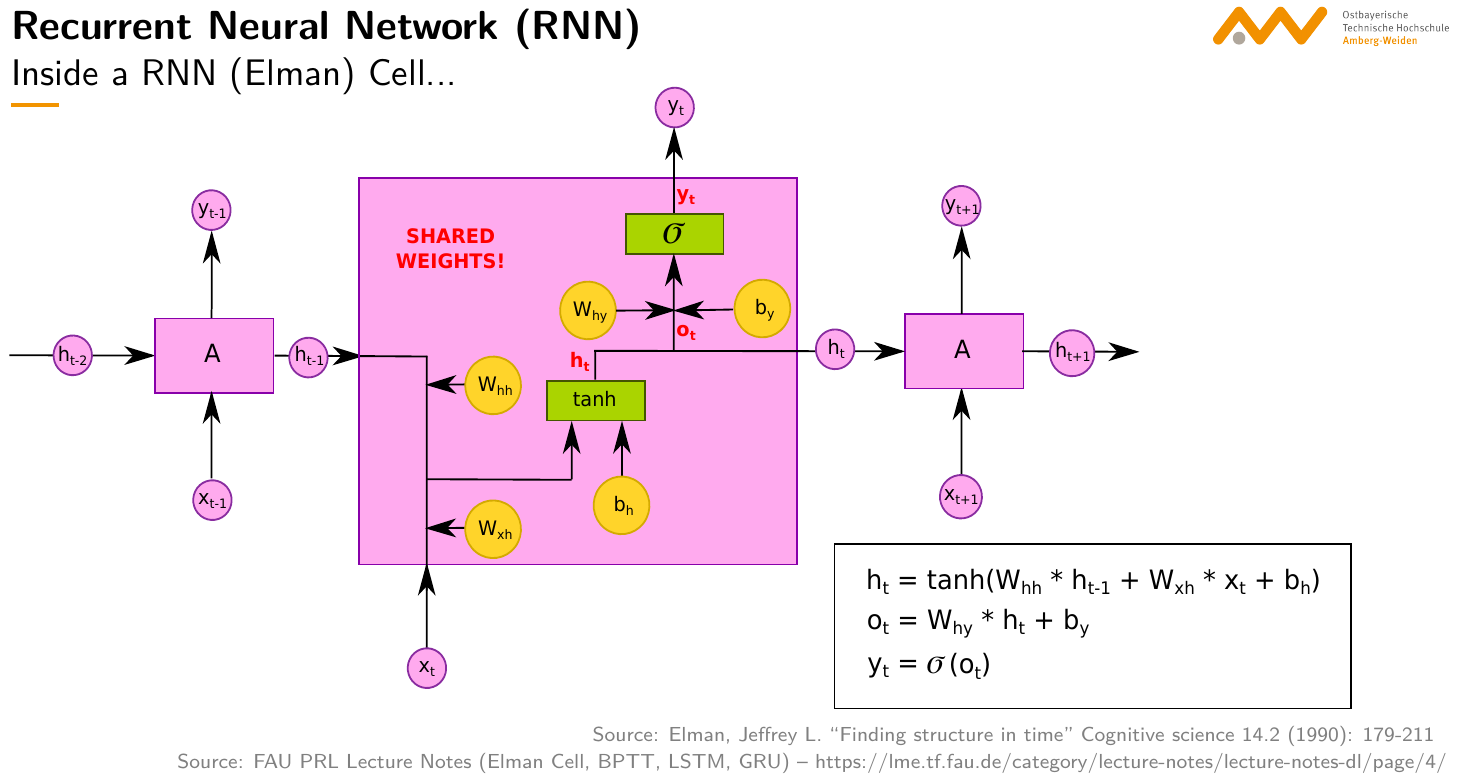

- For neural networks so far we could compute the hidden layer $h_t$ at position $t$ from the inputs at position $t-1$: $h_t = \phi(W_{xh} h_{t-1} + b_h)$ (for a hidden layer) or $h_t = \phi(W_{xh} x_{t} + b_h)$ (for the input layer)

- In the recurrent neural network setup, this changes to $h_t = \phi(W_{xh} x_t + W_{hh} h_{t-1} + b_h)$ where we incorporate the hidden information from the previous sequence position, too

- Basically speaking, our current input $x_t$ is concatenated with the hidden state $h_{t-1}$ from the previous step, which represents the foundation to compute the output $y_t$, as well as the updated hidden state information $h_t$, both  at time step $t$

## Vanishing and Exploding Gradients

- RNN introduces additional complexity compared to the traditional backpropagation algorithm in feedforward neural networks, due to the fact that the acutal hidden layer is not only dependent on the corresponding input $x$ at time point $t$ but also on the previous hidden layer $h_{t-1}$ at time point $t-1$

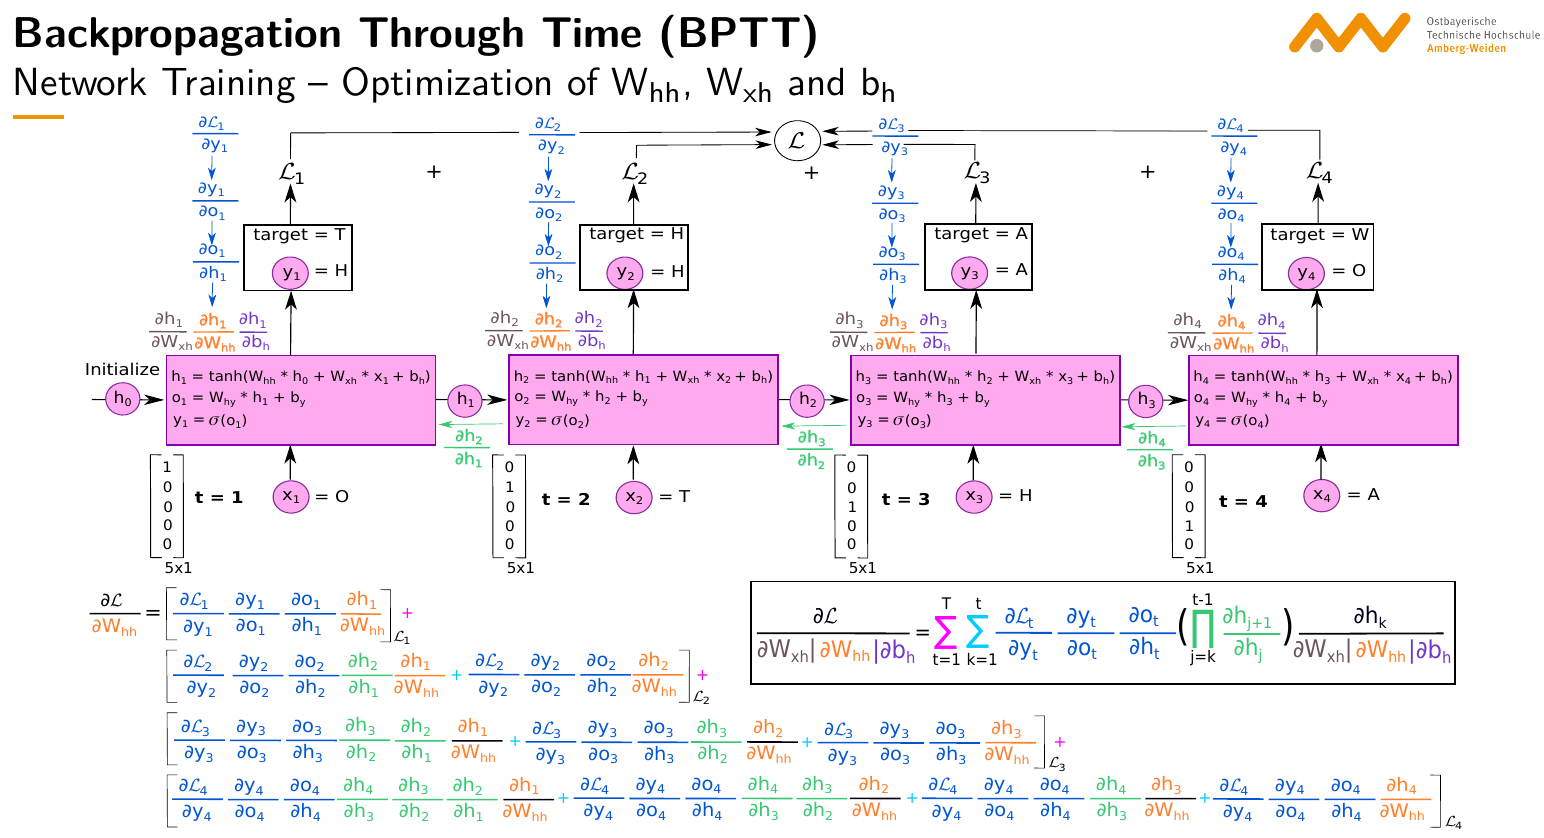

The loss for a sequence of length $T$ depends on the inputs, ground truth, and weights is composed of a sum of the individual losses at each step of the sequence

$$
L(x_1, \ldots, x_T, g_1, \ldots, g_T, W_{hh}, W_{xh}, W_{hy}, b_h, b_y) = \frac{1}{T}\sum_{t=1}^T L(g_t, y_t)
$$

with $g_t$ as ground truth at time point $t$, together with each associated loss term $L(y_t, g_t)$ at time point $t$. All the individual model predictions $y$ depend on $x_t, h_{t-1}, W_{hh}, W_{xh}, W_{hy}, b_h,$ and $b_y$

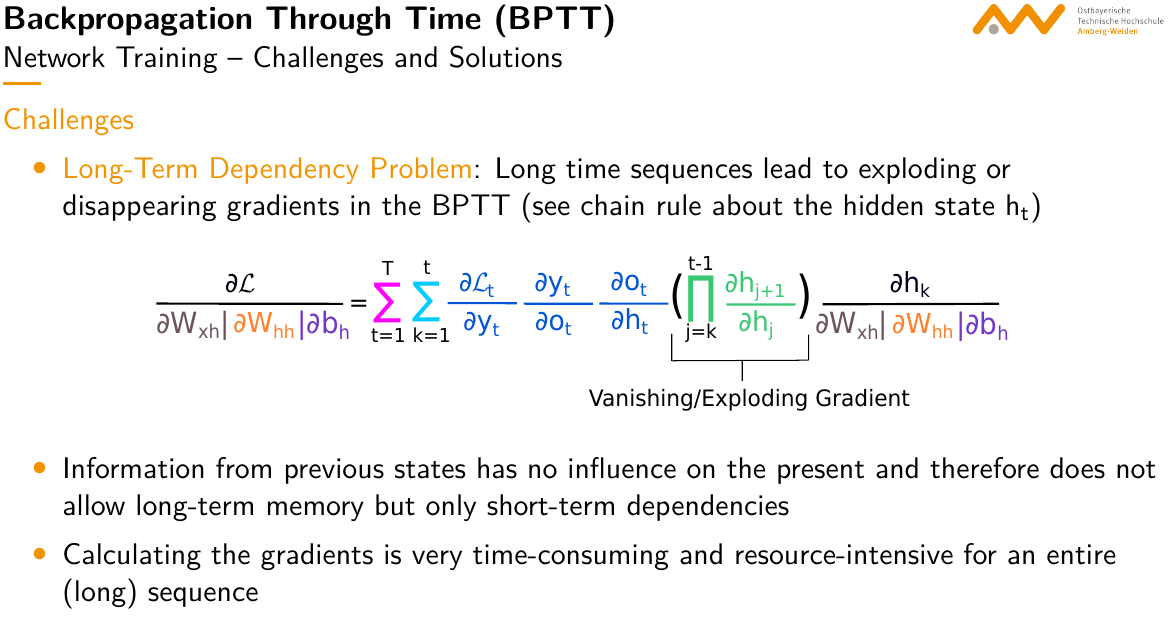

- Remembering that we sum the $t$ from $1$ to $T$ we see that we require a huge amount of memory and have a considerable potential for numerical instability: Small gradients in some part of the sequence can lead to vanishing gradients (no more or very slowed down propgress in learning) or to exploding gradients (iterations diverge). Small variations in the initial conditions thus have a huge potential to effect the outcome, therefore _full computation_ of the gradient is hardly used. There are other strategies to counteract the problem:

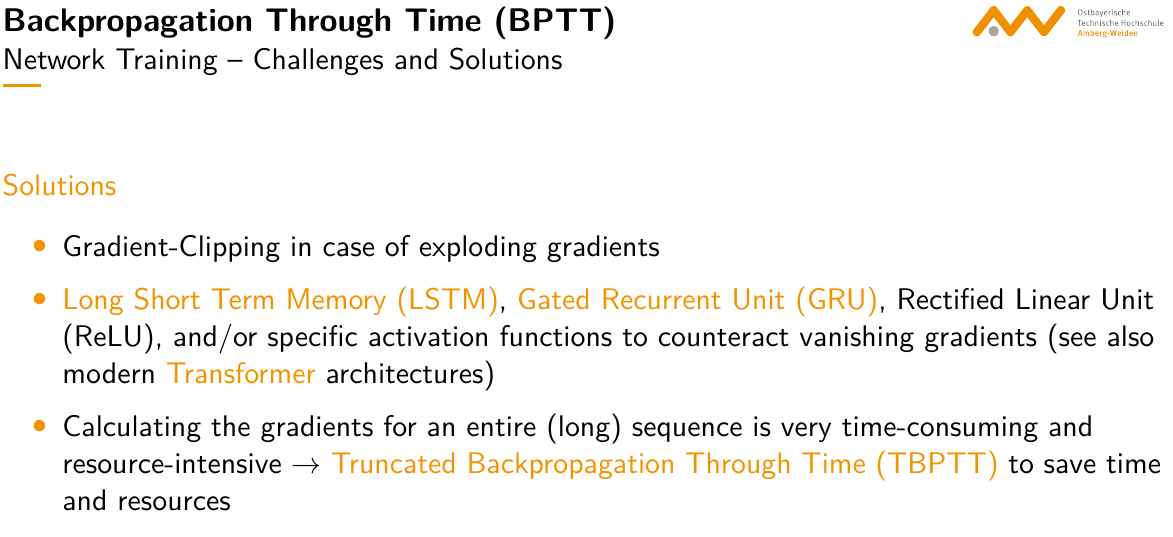

- What might seem a rough approximation leads to simpler and thus more stable models in practice. The gradient is determined by the short-term influences and neglects the long-term ones

## Programming Task

### Introduction

To have something illustrative let's build a character level text completion network. 

The model itself is still comparetevily simple, there is a discrete set of possible characters (less than 100, including special tokens, numbers, ...).

As dataset we will again use the "The Time Machine" example.


- Load the `time_machine.txt` data file

In [47]:
with open("time_machine.txt", 'r', encoding='utf-8-sig') as fh:
    text = fh.read()
    text = text.lower()

### Model Architecture

- Fill the code skeleton of the given `CharRNN` module: `__init__` (constructor, initialize the model), `forward` (forward path computation), and `init_hidden` (initialize hidden state with `zeros`)
- Create an `embedding layer` by using `nn.Embedding` in order to convert and encode a given input of dimension `input_size` to an embedding of dimension `emb_size` (Idea: transform a given input character $c$ into an embedding vector $e$ of a specified length, which is learned during the training process)
- Create a `RNN` layer by using `nn.RNN` which receives an input of dimension `emb_size` and applies an internal feature transformation with a hidden dimension of `hidden_size`
- Create a `Fully-Connected (Linear) Layer` to convert the incoming information of dimension `hidden_size` to the final output of dimension `output_size`
- The output should be transformed to a probability vector via a `softmax` (Do we really need to add the `softamx layer` to the model architecture (Hint: think about how the softmax output looks like for very small values (network outputs) and for very high values? Is a very small (negative) value also a small probability and vice versa, a high value close to a probability of one?)

The model assigns its input character the most likely follower character or in other words, you put in the character at position $t$ and get a prediction for the character at position $t+1$.

Hence we're dealing with a classification problem (since it is a prediction among discrete choices).

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [49]:
class CharRNN(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, output_size):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, emb_size)
        self.rnn = nn.RNN(emb_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        x = input.view(1, -1)
        x = self.embedding(x)
        output, hidden = self.rnn(x, hidden)
        output = self.fc(output.view(1,-1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

### Data Preprocessing

- Only use text information after the `String s =  *** START OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***` and convert the remaining text information to `lower case`
- Create a sorted `set` of all the characters (`char` symobls), including punctuation marks, digits, alphabetic letters, representing the number of different `chars`
- Build two `dictonaries` - `char` to `index` versus `index` to `char`, in order to ensure fast transformations in both directions (e.g. `{"a" : 0}` vs. `{0 : "a"}`)

In [50]:
split = '*** START OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***'
index = text.find(split)
cut_text = text[index + len(split):]

In [51]:
chars = sorted(set(cut_text)) 
char_to_index = {char: index for index, char in enumerate(chars)}
print(char_to_index)
index_to_char = {index: char for char, index in char_to_index.items()}
print(index_to_char)

{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6, "'": 7, '(': 8, ')': 9, '*': 10, ',': 11, '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, ';': 26, '?': 27, '[': 28, ']': 29, '_': 30, 'a': 31, 'b': 32, 'c': 33, 'd': 34, 'e': 35, 'f': 36, 'g': 37, 'h': 38, 'i': 39, 'j': 40, 'k': 41, 'l': 42, 'm': 43, 'n': 44, 'o': 45, 'p': 46, 'q': 47, 'r': 48, 's': 49, 't': 50, 'u': 51, 'v': 52, 'w': 53, 'x': 54, 'y': 55, 'z': 56, 'æ': 57, 'ç': 58, 'ü': 59, 'œ': 60, '—': 61, '‘': 62, '’': 63, '“': 64, '”': 65, '…': 66}
{0: '\n', 1: ' ', 2: '!', 3: '"', 4: '#', 5: '$', 6: '%', 7: "'", 8: '(', 9: ')', 10: '*', 11: ',', 12: '-', 13: '.', 14: '/', 15: '0', 16: '1', 17: '2', 18: '3', 19: '4', 20: '5', 21: '6', 22: '7', 23: '8', 24: '9', 25: ':', 26: ';', 27: '?', 28: '[', 29: ']', 30: '_', 31: 'a', 32: 'b', 33: 'c', 34: 'd', 35: 'e', 36: 'f', 37: 'g', 38: 'h', 39: 'i', 40: 'j', 41: 'k', 42: 'l', 43: 'm', 44: 'n', 45: 'o',

### Model Hyperparameter

- Define the value `input_size` and `output_size` by choosing the size of the `char set`

In [52]:
#TODO - try different values
emb_size = 128 #TODO
hidden_size = 64 #TODO
num_epochs = 100 #TODO
learning_rate = 0.01 #TODO
input_size = chars.__len__()
output_size = chars.__len__()

### Instantiate the Model

- Create the model with the mandatory input parameter: `input_size, emb_size, hidden_size, output_size`
- Define as Loss-Function the `CrossEntropyLoss`
- Specify the Optimizer by using the `Adam` option, together with the previously defined `learning rate`  

In [53]:
model = CharRNN(input_size, emb_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Training the Model

- Train the model for a total of `N` epochs (of course you can play around with the above hyperparameters)
- Put the model into `train` mode, set the gradients to `zero`,  initialize the hidden state using the previously defined `init_hidden()` function
- Loop over the entire `training_text` sequence
- Extract the `char` at the given time step $t$ from the respective text (input)
- Extract the `char` at the next time step $t+1$ (target, ground truth) from the respective text
- Convert `char` at time point $t$ to the corresponding index, representing the model input as `pytorch tensor`
- Convert `char` at time point $t+1$ to the corresponding index, representing the model output as `pytorch tensor`
- Compute the `output` and new `hidden` representation by applying the model
- Call the `cross entropy loss`, compute the loss, and accumulate it over the entire text sequence
- Add the final loss for one epoch and the entire `training_text` size to a list for downstream visualization
- Compute `backward` propagation and call the optimizer `step` function
- Report training loss per epoch

Hint: Follow the very similar trainings routine as for the PyTorch exercie (linear regression example) and fully-connected architecture 

In [54]:
limit = 2000 # for technical testing (whether the code runs or the output is plausible) you can limit the amount of text

training_text = cut_text[:min(len(cut_text), limit)]
losses = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    hidden = model.init_hidden()
    loss = 0

    for char_idx in range(len(training_text) - 1):
        
        char = cut_text[char_idx]
        
        target_char = cut_text[char_idx+1]
        
        inp = torch.tensor([char_to_index[char]], dtype=torch.long)
        
        target = torch.tensor([char_to_index[target_char]], dtype=torch.long)

        output, hidden = model(inp, hidden)

        loss += criterion(output, target)

    losses.append(loss)
    
    #TODO - backpropagation and weight update
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}')

 10%|█         | 10/100 [00:11<01:53,  1.26s/it]

Epoch: 10/100, Loss: 5021.708984375


 20%|██        | 20/100 [00:22<01:32,  1.15s/it]

Epoch: 20/100, Loss: 4399.77001953125


 30%|███       | 30/100 [00:36<01:47,  1.54s/it]

Epoch: 30/100, Loss: 3921.697998046875


 40%|████      | 40/100 [00:48<01:20,  1.33s/it]

Epoch: 40/100, Loss: 3467.069091796875


 50%|█████     | 50/100 [01:00<00:57,  1.14s/it]

Epoch: 50/100, Loss: 3040.2646484375


 60%|██████    | 60/100 [01:12<00:50,  1.25s/it]

Epoch: 60/100, Loss: 2621.47216796875


 70%|███████   | 70/100 [01:24<00:33,  1.10s/it]

Epoch: 70/100, Loss: 2215.440185546875


 80%|████████  | 80/100 [01:37<00:24,  1.24s/it]

Epoch: 80/100, Loss: 1858.2564697265625


 90%|█████████ | 90/100 [01:48<00:10,  1.03s/it]

Epoch: 90/100, Loss: 1547.702880859375


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]

Epoch: 100/100, Loss: 1329.0853271484375


- Visualize the epoch-specific `loss values` as part of a `line plot`, making use of the previously stored loss information

In [57]:
import matplotlib.pyplot as plt


### Text Generation via the trained Model
- Use the trained model to generate a sequence of chars, by starting with a `start_char` and a number of predictions (`num_predictions`) which determines the sentence length
- Put the model to the `eval` mode
- Conver the given `char` to an index, which represents the input
- Compute `num_predictions` many `char` symbols and just concatenate them
- At the end, print the final sentence - Meaningful result?

In [58]:
start_char = 'a'
num_predictions = 300

model.eval()

input = torch.tensor([char_to_index[start_char]], dtype=torch.long)
predicted_text = start_char

for _ in range(num_predictions):
    output, hidden = model(input, hidden)
    _, predicted_index = torch.max(output, 1)
    predicted_char = index_to_char[predicted_index.item()]
    predicted_text += predicted_char
    input = predicted_index

print("Generated Text: ", predicted_text)

Generated Text:  at recention
 ii the time machine

an inver the time traveller (for the time traveller (for the time traveller (for the time traveller (for the time traveller (for the time traveller (for the time traveller (for the time traveller (for the time traveller (for the time traveller (for the time travelle
